In [1]:
import pandas as pd
import pickle
from datetime import datetime
import bz2

In [2]:
!ls data/

09_prepared.pkl.bz2  card_lbe.pkl.bz2	    products_20201101.txt
10_prepared.pkl.bz2  doc_lbe.pkl.bz2	    product_sum_20201001.txt
11_prepared.pkl.bz2  products_20200901.txt


# Read data

In [2]:
# Files with raw data
FILE_PATHS = ['data/products_20200901.txt', 'data/product_sum_20201001.txt', 'data/products_20201101.txt']

# Files of data preprocessed with lab2.1
DF_PATHS = ['data/09_prepared.pkl.bz2', 'data/10_prepared.pkl.bz2', 'data/11_prepared.pkl.bz2']

# File to work with
WORKING_FILE = DF_PATHS[0]

### Read raw data file

In [7]:
# Data columns
colunms = [
    'date',       # The timestamp of the purchase
    'id_doc',     # Receipt's id
    'id_order',   # Order's id. Equals to 0 for offline purchases, another values for online purchases.
    'id_card',    # Unique id of customer (credit card)
    'id_tov',     # Unique id of product
    'id_kontr',   # Distributor's id
    'quantity',   # The amount of the same product in receipt which was purchased
    'sum',        # Price of the product
    'is_green'    # Shows that product is under discount or not
]

# Finction to parse the time string
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Read the data
df = pd.read_csv(
    filepath_or_buffer=WORKING_FILE,
    header=0,
    sep=';',
    names = colunms,
    usecols = colunms,
    parse_dates=['date'],
    date_parser=dateparse
)

# Show some examples
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271.0,"1,000",108,0
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271.0,"1,000",108,0
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271.0,"1,000","107,95",0
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271.0,"1,000",108,0
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97.0,"2,000",88,0


### Read prepared data file

In [3]:
def read_prepared(file_path):
    with bz2.open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Data analysis

### General overview

Showing some samples from the data

In [5]:
df_09 = read_prepared(DF_PATHS[0])
df_09.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.0,108.00,False,1538855,1283228
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271,1.0,108.00,False,267307,8873113
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271,1.0,107.95,False,610220,12712899
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271,1.0,108.00,False,441497,21535283
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97,2.0,88.00,False,1065358,642341


Checking there is no explisit None values

In [41]:
df_09.loc[:, df_09.isnull().any()].columns

Index([], dtype='object')

Overall number of records:

In [9]:
len(df_09)

42100858

For day grouping, it will be mode convenient to have separate column with just day of purchase

In [6]:
df_09['day'] = df_09['date'].dt.date

In [6]:
df_09.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.0,108.00,False,1538855,1283228,2020-09-01
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271,1.0,108.00,False,267307,8873113,2020-09-01
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271,1.0,107.95,False,610220,12712899,2020-09-01
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271,1.0,108.00,False,441497,21535283,2020-09-01
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97,2.0,88.00,False,1065358,642341,2020-09-01


As we can see, there no columns with None values. The None values in `id_kontr` are substituted with -9999

In [42]:
df_09[df_09['id_kontr']==-9999]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
73,2020-09-01 18:23:24,DCD681FA-67EC-EA11-B444-005056A7539A,0,1452280,185,-9999,1.0,129.0,False,267280,20201547,2020-09-01
126,2020-09-01 18:45:27,1606023F-6BEC-EA11-B444-005056A7539A,0,4475695,372,-9999,1.0,82.0,False,813975,2013970,2020-09-01
127,2020-09-01 20:55:22,AB82A13B-7DEC-EA11-B444-005056A7539A,0,5167781,372,-9999,1.0,82.0,False,956636,15689998,2020-09-01
128,2020-09-01 20:45:49,AE21D94F-7BEC-EA11-B444-005056A7539A,0,9813162,372,-9999,1.0,82.0,False,1675917,15929960,2020-09-01
199,2020-09-01 14:53:45,03E52BAA-4AEC-EA11-B444-005056A7539A,0,7632871,647,-9999,1.0,5.0,False,1408576,356179,2020-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...
42100548,2020-09-30 09:55:46,8B9DC82F-EA02-EB11-B444-005056A7539A,0,3990786,37280,-9999,2.0,110.0,False,708037,12774423,2020-09-30
42100659,2020-09-30 14:27:49,76AA193B-1003-EB11-B444-005056A7539A,0,0939821,27871,-9999,1.0,70.0,False,176363,10856534,2020-09-30
42100660,2020-09-30 13:12:55,17B738C1-0603-EB11-B444-005056A7539A,0,a422949,27873,-9999,1.0,100.0,False,1903097,2168885,2020-09-30
42100661,2020-09-30 09:02:46,3210F0AF-E202-EB11-B444-005056A7539A,0,5004147,27873,-9999,1.0,100.0,False,925410,4578578,2020-09-30


Creatinh storage for fake ids found

In [6]:
fake_id_card_int = []

### Looking for strangely frequent buyers
The data is provided by supermarket where people can buy goods online (`id_order` is not 0) and offline (`id_order` is 0). We are interested in "people" with strange behaviour, meaning that they are not real castomers.

The first step: count the number of orders for each person ad look for cads with too frequent purchases.

<AxesSubplot:>

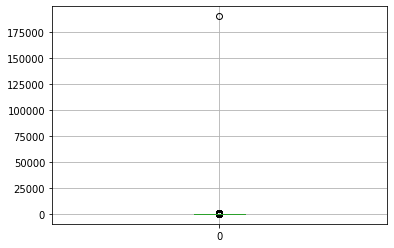

In [43]:
order_count = df_09.groupby(['id_card_int']).size()
pd.DataFrame(order_count).boxplot()

We see that one customer has much more purchases then other customers.
Lets see the full stat for it

Get the card_id, in parallel checking that it is the only one:

In [53]:
order_count[order_count > 25000]

id_card_int
883386    189812
dtype: int64

In [50]:
order_count[order_count == order_count.max()]

id_card_int
883386    189812
dtype: int64

Number of his orders per day:

In [51]:
df_09[df_09['id_card_int']==883386].groupby('day').size()

day
2020-09-01    6283
2020-09-02    6266
2020-09-03    6528
2020-09-04    6386
2020-09-05    6110
2020-09-06    6234
2020-09-07    6436
2020-09-08    6475
2020-09-09    6435
2020-09-10    6315
2020-09-11    6303
2020-09-12    6003
2020-09-13    6079
2020-09-14    6419
2020-09-15    6481
2020-09-16    6385
2020-09-17    6355
2020-09-18    6319
2020-09-19    6127
2020-09-20    6078
2020-09-21    6365
2020-09-22    6442
2020-09-23    6530
2020-09-24    6478
2020-09-25    6501
2020-09-26    6161
2020-09-27    6208
2020-09-28    6456
2020-09-29    6224
2020-09-30    6430
dtype: int64

General stats:

In [52]:
df_09[df_09['id_card_int']==883386].describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int
count,189812.0,189812.000000,189812.000000,189812.000000,189812.000000,189812.0,1.898120e+05
mean,0.0,21936.386751,11188.841606,1.206576,96.195667,883386.0,1.173007e+07
std,0.0,9589.441383,8258.660083,22.599737,60.969901,0.0,6.792088e+06
min,0.0,46.000000,-9999.000000,0.004000,0.000000,883386.0,1.200000e+01
25%,0.0,18077.000000,12320.000000,1.000000,45.000000,883386.0,5.822517e+06
50%,0.0,21942.000000,13614.000000,1.000000,85.000000,883386.0,1.177494e+07
75%,0.0,28799.000000,15916.000000,1.000000,142.000000,883386.0,1.763479e+07
max,0.0,38587.000000,21943.000000,5000.000000,756.000000,883386.0,2.341747e+07


Interestingly, this person does 6k orders per day offline. Moreover, most of the orders has only 1 item in list (in 75% definitelly). I find it more than strange. The only one possible meaning may be that this is some big customer that uses this store as product source. But as it is the only one with such behaviour from all, I conclude that this card is likely to be fake.

In [21]:
fake_id_card_int.append(883386)

Analysis without such person

<AxesSubplot:>

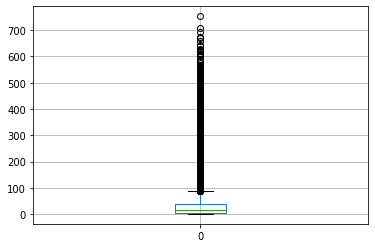

In [56]:
order_count = df_09[df_09['id_card_int']!=883386].groupby(['id_card_int']).size()
pd.DataFrame(order_count).boxplot()

In [57]:
order_count[order_count>100]

id_card_int
10         120
19         445
22         175
25         254
30         190
          ... 
1929334    121
1929351    119
1929735    153
1929905    161
1941912    121
Length: 94474, dtype: int64

I cannot say from such plot if there is more such outliers.

### Looking for too many products in one order

<AxesSubplot:>

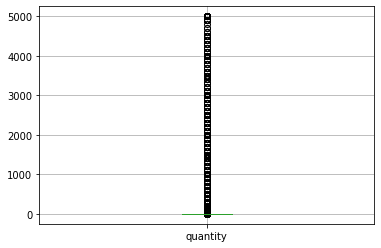

In [58]:
pd.DataFrame(df_09['quantity']).boxplot()

<AxesSubplot:>

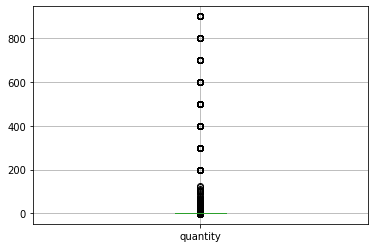

In [7]:
pd.DataFrame(df_09[df_09['quantity']<1000]['quantity']).boxplot()

In [18]:
len(df_09[df_09['quantity']>=200]['quantity'])

4686

There is clear strange orders with quantity more or equal to 200 - they are equally distanced from each other with the step of 50 tems. As there is only 4686 such orders from several million, I undersatnd them as outliers

In [19]:
df_09[df_09['quantity']>=200].describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int
count,4686.0,4686.0,4686.0,4686.000000,4686.0,4.686000e+03,4.686000e+03
mean,0.0,1113.0,-9999.0,2329.641485,0.0,8.873411e+05,1.187524e+07
std,0.0,0.0,0.0,1792.888406,0.0,5.234381e+05,6.807760e+06
min,0.0,1113.0,-9999.0,200.000000,0.0,1.500000e+01,3.007000e+03
25%,0.0,1113.0,-9999.0,700.000000,0.0,4.220375e+05,5.983224e+06
50%,0.0,1113.0,-9999.0,2000.000000,0.0,9.210990e+05,1.206742e+07
75%,0.0,1113.0,-9999.0,4000.000000,0.0,1.315537e+06,1.776933e+07
max,0.0,1113.0,-9999.0,5000.000000,0.0,1.902460e+06,2.341278e+07


More evidences - same product id (`id_tov`), same distributor id (`id_kontr` - all are Nones!) and all orders has 0 cost. But individually customest do not look like fake ones, may be this is some order artifacts.

### Looking for too few products in one order

<AxesSubplot:>

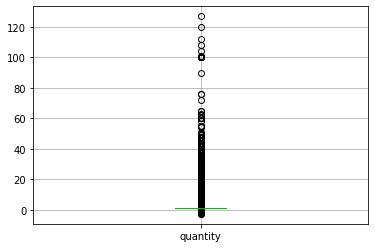

In [6]:
pd.DataFrame(df_09[df_09['quantity']<150]['quantity']).boxplot()

We can notice here items with negative prices

<AxesSubplot:>

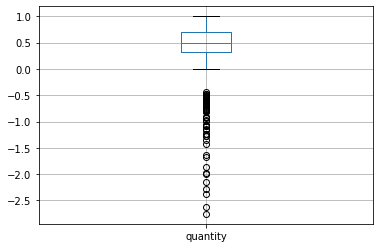

In [7]:
pd.DataFrame(df_09[df_09['quantity']<1]['quantity']).boxplot()

In [8]:
df_09[df_09['quantity']<0].describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int
count,6.800000e+01,68.0,68.0,68.000000,68.000000,6.800000e+01,6.800000e+01
mean,8.318366e+04,23074.0,19269.0,-0.972588,360.830588,7.671420e+05,1.320781e+07
std,6.859500e+05,0.0,0.0,0.575837,213.636198,5.422148e+05,6.931748e+06
min,0.000000e+00,23074.0,19269.0,-2.755000,0.370000,2.823800e+04,1.115526e+06
25%,0.000000e+00,23074.0,19269.0,-1.174000,218.705000,2.957038e+05,6.620934e+06
50%,0.000000e+00,23074.0,19269.0,-0.777000,288.270000,6.594350e+05,1.391241e+07
75%,0.000000e+00,23074.0,19269.0,-0.589500,435.557500,1.280890e+06,1.972953e+07
max,5.656489e+06,23074.0,19269.0,-0.001000,1022.110000,1.837262e+06,2.287165e+07


Same distributor, same probuct. Check where else this distributor appears

In [9]:
df_09[df_09['id_kontr']==19269.0].describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int
count,1.753820e+05,175382.000000,175382.0,175382.000000,175382.000000,1.753820e+05,1.753820e+05
mean,5.064799e+05,23038.987353,19269.0,0.952068,214.219986,8.368067e+05,1.169848e+07
std,1.685642e+06,323.605369,0.0,0.638962,148.819002,5.309799e+05,6.755727e+06
min,0.000000e+00,15917.000000,19269.0,-2.755000,-1022.110000,1.100000e+01,3.630000e+02
25%,0.000000e+00,23074.000000,19269.0,0.552000,124.080000,3.662940e+05,5.844407e+06
50%,0.000000e+00,23074.000000,19269.0,0.730000,166.380000,8.055620e+05,1.169415e+07
75%,0.000000e+00,23074.000000,19269.0,1.176000,267.340000,1.269221e+06,1.754828e+07
max,6.672207e+06,23074.000000,19269.0,18.070000,3541.720000,1.932650e+06,2.341768e+07


This distributor has mostly only one product (>75% of `id_tov` is 23074)
But there is small amount of strange negative quantity

Check also card ids appeared with negative quantities

In [13]:
df_09[df_09['id_card_int'].isin(df_09[df_09['quantity']<0]['id_card_int'].values)].describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int
count,4.973000e+03,4973.000000,4973.000000,4973.000000,4973.000000,4.973000e+03,4.973000e+03
mean,8.340723e+05,17812.022321,10764.178363,1.179998,116.490485,7.750042e+05,1.175952e+07
std,2.084794e+06,10624.093710,9213.548171,0.892593,124.773097,5.398220e+05,6.781292e+06
min,0.000000e+00,52.000000,-9999.000000,-2.755000,-1022.110000,2.823800e+04,1.364400e+04
25%,0.000000e+00,14962.000000,10834.000000,1.000000,50.540000,3.081540e+05,5.698590e+06
50%,0.000000e+00,19909.000000,14003.000000,1.000000,95.000000,7.078150e+05,1.195701e+07
75%,0.000000e+00,23555.000000,17138.000000,1.000000,161.000000,1.301664e+06,1.785264e+07
max,6.649713e+06,38460.000000,21943.000000,20.000000,1659.900000,1.837262e+06,2.341441e+07


I can not call such cards outliers, but concrete order elements - yes.

### Looking for orders with negative cost

In [18]:
pd.DataFrame(df_09[df_09['sum']<0]).describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int
count,6.900000e+01,69.000000,69.000000,69.000000,69.000000,6.900000e+01,6.900000e+01
mean,1.774443e+05,23065.565217,18991.217391,0.972986,-355.601304,7.606911e+05,1.321279e+07
std,1.037631e+06,70.064566,2307.435646,0.571597,216.462642,5.408742e+05,6.880715e+06
min,0.000000e+00,22492.000000,102.000000,0.001000,-1022.110000,2.823800e+04,1.115526e+06
25%,0.000000e+00,23074.000000,19269.000000,0.590000,-428.880000,3.081540e+05,6.745380e+06
50%,0.000000e+00,23074.000000,19269.000000,0.778000,-287.900000,6.110550e+05,1.391053e+07
75%,0.000000e+00,23074.000000,19269.000000,1.156000,-218.150000,1.273966e+06,1.966137e+07
max,6.587167e+06,23074.000000,19269.000000,2.755000,-0.010000,1.837262e+06,2.287165e+07


Here we notice the same `id_tov` 23074 and same `id_kontr` 19269 in the majority of such orders.

### Looking for strangely big costs

<AxesSubplot:>

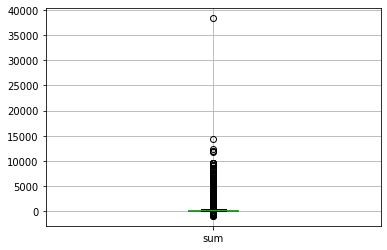

In [19]:
pd.DataFrame(df_09['sum']).boxplot()

There are visible outliers with cost higher then 10 000.

In [20]:
df_09[df_09['sum']>10000]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
14117097,2020-09-11 08:06:39,439114CA-ECF3-EA11-B444-005056A7539A,0,8468634,16306,13983,76.0,12388.0,False,1524177,6178365,2020-09-11
30839922,2020-09-23 13:55:46,D3CC9C1C-8CFD-EA11-B444-005056A7539A,0,5051239,19493,12320,45.0,11745.0,False,935791,19375361,2020-09-23
37540025,2020-09-28 15:32:19,C742CB6B-8701-EB11-B444-005056A7539A,0,A634010,21379,15189,5.0,12000.0,False,1755035,18226861,2020-09-28
37540026,2020-09-28 15:33:25,CB42CB6B-8701-EB11-B444-005056A7539A,0,A634010,21379,15189,5.0,12000.0,False,1755035,18593568,2020-09-28
38060134,2020-09-28 08:36:51,9B6A36BF-4C01-EB11-B444-005056A7539A,6518049,A634010,21379,18018,16.0,38400.0,False,1755035,14218897,2020-09-28
38216962,2020-09-28 13:08:28,A468D059-7301-EB11-B444-005056A7539A,0,A634010,21379,15189,6.0,14400.0,False,1755035,15041220,2020-09-28


The most expencive purchases are for 21379 product - which is 'икра' - so it is ok.

In [27]:
df_09[df_09['id_card_int']==1755035]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
37540025,2020-09-28 15:32:19,C742CB6B-8701-EB11-B444-005056A7539A,0,A634010,21379,15189,5.0,12000.0,False,1755035,18226861,2020-09-28
37540026,2020-09-28 15:33:25,CB42CB6B-8701-EB11-B444-005056A7539A,0,A634010,21379,15189,5.0,12000.0,False,1755035,18593568,2020-09-28
37543109,2020-09-28 14:00:04,1FF3AD16-7A01-EB11-B444-005056A7539A,0,A634010,21379,15189,2.0,4800.0,False,1755035,2923518,2020-09-28
37696290,2020-09-28 13:29:03,9563B6EF-7601-EB11-B444-005056A7539A,0,A634010,21379,15189,1.0,1800.6,True,1755035,13667043,2020-09-28
37696291,2020-09-28 13:29:03,9563B6EF-7601-EB11-B444-005056A7539A,0,A634010,21379,15189,1.0,1800.6,True,1755035,13667043,2020-09-28
37706914,2020-09-28 16:05:19,14486D8B-8B01-EB11-B444-005056A7539A,0,A634010,21379,15189,2.0,4800.0,False,1755035,1855111,2020-09-28
38058645,2020-09-28 08:36:51,9B6A36BF-4C01-EB11-B444-005056A7539A,6518049,A634010,647,13567,1.0,5.0,False,1755035,14218897,2020-09-28
38060133,2020-09-28 08:36:51,9B6A36BF-4C01-EB11-B444-005056A7539A,6518049,A634010,21379,15189,4.0,9600.0,False,1755035,14218897,2020-09-28
38060134,2020-09-28 08:36:51,9B6A36BF-4C01-EB11-B444-005056A7539A,6518049,A634010,21379,18018,16.0,38400.0,False,1755035,14218897,2020-09-28
38069401,2020-09-28 12:30:21,62FE2F59-6E01-EB11-B444-005056A7539A,0,A634010,21379,15189,3.0,7200.0,False,1755035,9054795,2020-09-28


But one person who have spended 110k for it in one day.. seems strange)

In [28]:
fake_id_card_int.append(1755035)

NameError: name 'fake_id_card_int' is not defined

### Looking for strangely small costs

In [29]:
df_09[df_09['sum']<0]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
4206092,2020-09-04 09:10:21,827B9591-75EE-EA11-B444-005056A7539A,0,7009929,23074,19269,1.268,-470.43,False,1301664,11939194,2020-09-04
4206102,2020-09-04 09:09:24,F6807973-75EE-EA11-B444-005056A7539A,0,7707981,23074,19269,1.268,-470.43,False,1419650,22549976,2020-09-04
4210124,2020-09-04 08:37:00,49C21AF5-70EE-EA11-B444-005056A7539A,0,5554550,23074,19269,1.084,-402.16,False,1035577,6745380,2020-09-04
4218019,2020-09-04 08:43:37,B681FEE3-71EE-EA11-B444-005056A7539A,0,0643258,23074,19269,0.001,-0.37,False,126995,16694740,2020-09-04
4218021,2020-09-04 08:43:37,B681FEE3-71EE-EA11-B444-005056A7539A,0,0643258,23074,19269,2.375,-881.13,False,126995,16694740,2020-09-04
...,...,...,...,...,...,...,...,...,...,...,...,...
5396780,2020-09-04 08:37:49,1CC214FB-70EE-EA11-B444-005056A7539A,0,4916790,23074,19269,1.236,-458.56,False,906517,2630312,2020-09-04
5438901,2020-09-04 09:28:21,E6F17E03-78EE-EA11-B444-005056A7539A,0,5931979,23074,19269,0.572,-212.21,False,1102820,21125316,2020-09-04
5450157,2020-09-04 09:21:17,CD1BCB2C-77EE-EA11-B444-005056A7539A,0,3290674,23074,19269,0.915,-339.47,False,574393,18763274,2020-09-04
5450159,2020-09-04 09:21:17,CD1BCB2C-77EE-EA11-B444-005056A7539A,0,3290674,23074,19269,0.915,-339.47,False,574393,18763274,2020-09-04


In [33]:
df_09[df_09['sum']<0].describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int
count,6.900000e+01,69.000000,69.000000,69.000000,69.000000,6.900000e+01,6.900000e+01
mean,1.774443e+05,23065.565217,18991.217391,0.972986,-355.601304,7.606911e+05,1.321279e+07
std,1.037631e+06,70.064566,2307.435646,0.571597,216.462642,5.408742e+05,6.880715e+06
min,0.000000e+00,22492.000000,102.000000,0.001000,-1022.110000,2.823800e+04,1.115526e+06
25%,0.000000e+00,23074.000000,19269.000000,0.590000,-428.880000,3.081540e+05,6.745380e+06
50%,0.000000e+00,23074.000000,19269.000000,0.778000,-287.900000,6.110550e+05,1.391053e+07
75%,0.000000e+00,23074.000000,19269.000000,1.156000,-218.150000,1.273966e+06,1.966137e+07
max,6.587167e+06,23074.000000,19269.000000,2.755000,-0.010000,1.837262e+06,2.287165e+07


Same 23074 product from 19269, but no strange customers detected

### Check is someone got to many orders in one day

<AxesSubplot:>

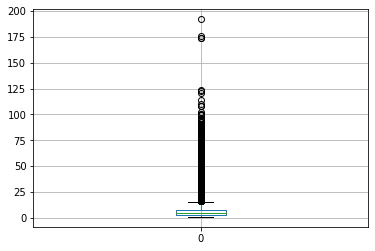

In [7]:
pd.DataFrame(df_09[df_09['id_card_int'] != 883386].groupby(['id_card_int', 'day']).size().values).boxplot()

There are some outliers with more then 150 orders in one day

In [8]:
df_09[df_09['id_card_int'] != 883386].groupby(['id_card_int', 'day']).size() > 150

id_card_int  day       
0            2020-09-07    False
             2020-09-09    False
             2020-09-10    False
             2020-09-11    False
             2020-09-12    False
                           ...  
1941912      2020-09-29    False
             2020-09-30    False
1944074      2020-09-09    False
             2020-09-14    False
             2020-09-24    False
Length: 6706744, dtype: bool

In [11]:
df_09[df_09['id_card_int'] == 1944074]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
12284750,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,143,-9999,1.00,104.00,False,1944074,2746927,2020-09-09
12284957,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,647,-9999,2.00,10.00,False,1944074,2746927,2020-09-09
12285047,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,933,-9999,1.00,99.00,False,1944074,2746927,2020-09-09
12285074,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,1087,-9999,2.00,112.00,False,1944074,2746927,2020-09-09
12285436,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,18273,-9999,1.00,58.00,False,1944074,2746927,2020-09-09
12286026,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,26439,-9999,2.00,268.00,False,1944074,2746927,2020-09-09
12286212,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,32384,-9999,1.00,140.00,False,1944074,2746927,2020-09-09
18629501,2020-09-14 20:11:59,C70F2B9D-AEF6-EA11-B444-005056A7539A,0,undefin,17823,12969,1.00,46.00,False,1944074,18208481,2020-09-14
18629950,2020-09-14 20:11:59,C70F2B9D-AEF6-EA11-B444-005056A7539A,0,undefin,22984,16340,1.00,100.00,False,1944074,18208481,2020-09-14
19047221,2020-09-14 20:58:31,A41592F2-B3F6-EA11-B444-005056A7539A,0,undefin,173,15385,2.00,104.00,False,1944074,15011738,2020-09-14


We cannot tell if  it is the same person with undefined card or several, so it is better to delete them

In [ ]:
fake_id_card_int.append(1944074)

# Same processing for October

In [5]:
# Read data
df_10 = read_prepared(DF_PATHS[1])
df_10['day'] = df_10['date'].dt.date

### Frequent buyers

<AxesSubplot:>

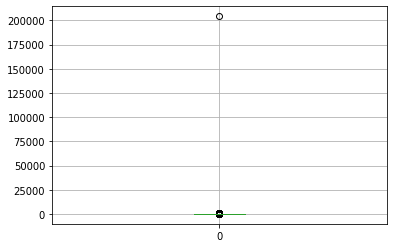

In [6]:
order_count = df_10.groupby(['id_card_int']).size()
pd.DataFrame(order_count).boxplot()

In [7]:
order_count[order_count > 25000]

id_card_int
883386    204271
dtype: int64

Same person from September)

### Looking for too many products in one order

<AxesSubplot:>

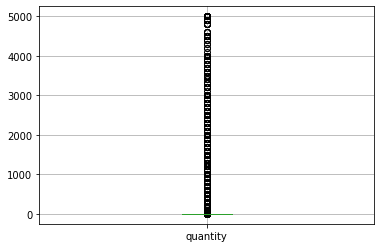

In [8]:
pd.DataFrame(df_10['quantity']).boxplot()

In [9]:
len(df_10[df_10['quantity']>=200]['quantity'])

4471

Same situation with quantity as multiplyer of 50

In [11]:
df_10[df_10['quantity']>=200]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
2772,2020-10-01 17:28:46,BC595F32-F303-EB11-B444-005056A7539A,0,8759249,1113,-9999,400.0,0.0,False,1557873,17229522,2020-10-01
28962,2020-10-01 17:31:59,B26660DE-F303-EB11-B444-005056A7539A,0,A069065,1113,-9999,4000.0,0.0,False,1707038,16319385,2020-10-01
39304,2020-10-01 17:08:19,79BDA536-F003-EB11-B444-005056A7539A,0,1001600,1113,-9999,3000.0,0.0,False,186522,11138055,2020-10-01
52704,2020-10-01 20:09:01,414CFB9E-0904-EB11-B444-005056A7539A,0,1059544,1113,-9999,500.0,0.0,False,197342,5971175,2020-10-01
68309,2020-10-01 11:35:31,D723F6FE-C103-EB11-B444-005056A7539A,0,5020692,1113,-9999,1900.0,0.0,False,929087,19680992,2020-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...
46021999,2020-10-31 18:34:53,19C45DCF-8E1B-EB11-B444-005056A7539A,0,5278611,1113,-9999,1000.0,0.0,False,978937,2356593,2020-10-31
46023960,2020-10-31 16:37:25,0B0E95CA-7E1B-EB11-B444-005056A7539A,0,4847991,1113,-9999,200.0,0.0,False,890425,1011643,2020-10-31
46056397,2020-10-31 16:29:35,D80C95CA-7E1B-EB11-B444-005056A7539A,0,1014610,1113,-9999,2000.0,0.0,False,188852,19764238,2020-10-31
46061087,2020-10-31 21:51:02,665F2A64-AA1B-EB11-B444-005056A7539A,0,0000456,1113,-9999,3500.0,0.0,False,105,9364322,2020-10-31


Same -9999 distributer for unnknown 1113 product. But customers are looking ok, they have quite diversed orders.

### Looking for too few products in one order

In [15]:
df_10[df_10['quantity']<0]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day


No negative amounts)

### Looking for orders with negative cost

In [17]:
df_10[df_10['sum']<0]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day


No negative costs)

### Looking for strangely big costs

<AxesSubplot:>

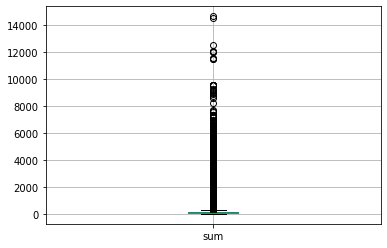

In [20]:
pd.DataFrame(df_10['sum']).boxplot()

In [21]:
df_10[df_10['sum']>10000]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
10724315,2020-10-08 12:27:02,49D00EA1-4809-EB11-B444-005056A7539A,0,5051239,16306,13983,77.0,12551.0,False,935791,6750354,2020-10-08
16560928,2020-10-12 12:07:23,5CA85114-6B0C-EB11-B444-005056A7539A,0,6050041,23239,14188,5.0,11500.0,False,1125200,8474794,2020-10-12
29857149,2020-10-21 09:41:52,6FD4492A-7513-EB11-B444-005056A7539A,7654429,2239700,21379,18018,4.0,12004.0,False,399162,10230292,2020-10-21
38189763,2020-10-26 10:13:18,59B79607-5B17-EB11-B444-005056A7539A,0,7978550,37400,-9999,4.0,14560.0,False,1458061,8205176,2020-10-26
38765804,2020-10-27 12:35:31,7728DD8C-3818-EB11-B444-005056A7539A,0,6907544,16306,13983,71.0,11573.0,False,1282717,10902040,2020-10-27
38999139,2020-10-27 11:21:00,EDA2B56B-2D18-EB11-B444-005056A7539A,8006612,A298975,488,-9999,41.0,12074.5,False,1728180,21737638,2020-10-27
40518221,2020-10-28 16:10:59,AF43196E-2019-EB11-B444-005056A7539A,0,4955624,21379,15189,5.0,12000.0,False,914433,16032966,2020-10-28
41374174,2020-10-28 16:21:52,3BCC3BF7-2119-EB11-B444-005056A7539A,0,0154217,23239,14188,5.0,11500.0,False,32211,5467424,2020-10-28
44362258,2020-10-30 15:25:34,4F7669D2-AB1A-EB11-B444-005056A7539A,0,8900357,31091,19653,23.0,14683.2,False,1574794,7267063,2020-10-30


No strange vehaviour

### Looking for strangely small costs

<AxesSubplot:>

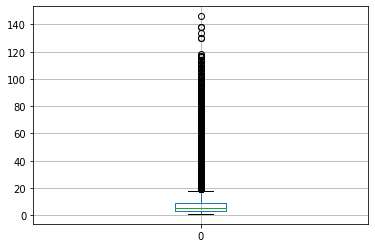

In [6]:
pd.DataFrame(df_10[df_10['id_card_int'] != 883386].groupby(['id_card_int', 'day']).size().values).boxplot()

# Same search for November

In [4]:
df_11 = read_prepared(DF_PATHS[2])
df_11['day'] = df_11['date'].dt.date

### Looking for strangely frequent buyers

<AxesSubplot:>

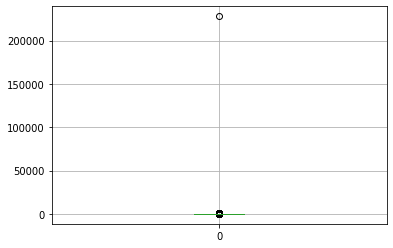

In [6]:
order_count = df_11.groupby(['id_card_int']).size()
pd.DataFrame(order_count).boxplot()

In [7]:
order_count[order_count > 25000]

id_card_int
883386    228012
dtype: int64

Same persom from previous months

### Looking for too many products in one order

<AxesSubplot:>

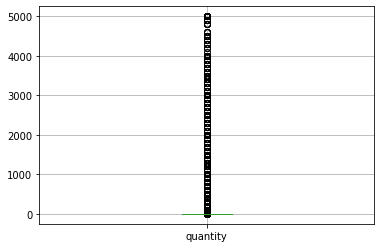

In [8]:
pd.DataFrame(df_11['quantity']).boxplot()

In [9]:
df_11[df_11['quantity']>=200]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
6749,2020-11-01 18:23:01,6610942A-571C-EB11-B444-005056A7539A,0,7723723,1113,-9999,2000.0,0.0,False,1422661,9336612,2020-11-01
19366,2020-11-01 11:45:06,38B9BED4-1E1C-EB11-B444-005056A7539A,0,C456412,1113,-9999,400.0,0.0,False,1863672,5186086,2020-11-01
24288,2020-11-01 20:49:28,0B8977D3-6A1C-EB11-B444-005056A7539A,0,B247082,1113,-9999,500.0,0.0,False,1808425,1055353,2020-11-01
47204,2020-11-01 12:30:00,C7C46B83-251C-EB11-B444-005056A7539A,0,8035107,1113,-9999,900.0,0.0,False,1466705,18273257,2020-11-01
80532,2020-11-01 15:13:38,AFF3C418-3C1C-EB11-B444-005056A7539A,0,6826233,1113,-9999,3000.0,0.0,False,1265600,16095999,2020-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...
46462107,2020-11-30 23:06:09,F490D6CA-4733-EB11-B444-005056A7539A,0,2951010,1113,-9999,5000.0,0.0,False,516678,22372786,2020-11-30
46465112,2020-11-30 13:28:49,22D65B5F-F732-EB11-B444-005056A7539A,0,6181374,1113,-9999,1000.0,0.0,False,1147227,3186500,2020-11-30
46470920,2020-11-30 08:54:36,1E9A13E3-D032-EB11-B444-005056A7539A,0,6362935,1113,-9999,1500.0,0.0,False,1176200,2799846,2020-11-30
46470921,2020-11-30 20:08:09,22425EB3-2F33-EB11-B444-005056A7539A,0,4159914,1113,-9999,5000.0,0.0,False,745459,3133830,2020-11-30


absolutely same situation, but card ids are semarately ok

In [10]:
df_11[df_11['quantity']>=200].groupby('id_card_int').size().sort_values()

id_card_int
19          1
1102745     1
1102727     1
1101493     1
1101355     1
           ..
1154256    12
883386     12
1151976    14
1463452    16
121339     18
Length: 2628, dtype: int64

Cannot say that they are fake...

### Looking for too few products in one order

In [11]:
df_11[df_11['quantity']<0]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day


Nothing strange

### Looking for orders with negative cost

In [12]:
df_11[df_11['sum']<0]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day


Nothing strange

### Looking for strangely big costs

<AxesSubplot:>

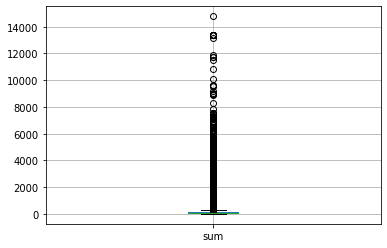

In [13]:
pd.DataFrame(df_11['sum']).boxplot()

In [16]:
df_11[df_11['sum']>8000].groupby("id_card_int").size()

id_card_int
154167     1
203589     1
362510     2
406840     1
474938     1
595730     1
613129     1
894071     1
935791     1
1011060    1
1125200    1
1174480    1
1225334    1
1313316    1
1373760    1
1524177    1
1577248    9
dtype: int64

In [18]:
df_11[df_11['id_card_int']==1577248].groupby('id_tov').size()

id_tov
647        3
21392      1
23074    784
23130      1
dtype: int64

In [19]:
df_11[df_11['id_card_int']==1577248].groupby('day').size()

day
2020-11-06    22
2020-11-07     3
2020-11-09    66
2020-11-12    47
2020-11-13    61
2020-11-14    33
2020-11-15    22
2020-11-16     7
2020-11-18    92
2020-11-19    16
2020-11-20    38
2020-11-21    45
2020-11-22    29
2020-11-24    72
2020-11-25    26
2020-11-26    84
2020-11-27    46
2020-11-28    40
2020-11-29    31
2020-11-30     9
dtype: int64

Strange person. He loves 23074 product..

# Result

In [21]:

# Not much, but honest work....
fake_id_card_int = [
    {"id_card_int":883386},
    {"id_card_int":1755035},
    {"id_card_int":1944074},
    {"id_card_int":1577248}
]

In [22]:
res = pd.DataFrame(fake_id_card_int, columns=['id_card_int'])
with open("fake_id_card_int.pkl", 'wb') as f:
    pickle.dump(res, f)